Importing Phase

In [63]:
# Imprort necessary libraries

import matplotlib as mpl
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import pandas as pd
from scipy.interpolate import splprep, splev


import fastf1 as ff1

Defining Some Variables

In [103]:
year = 2024
wknd = 5
ses = 'R'
driver = 'HAM'

colormap = mpl.colormaps['summer_r']

Loading the Session and Exctracting Some Data

In [75]:
# Load the session and the weekend
session = ff1.get_session(year, wknd, ses)
print("Session: \n")
print(session)
weekend = session.event
print("weekend: \n")
print(weekend)
session.load()

# Extract the fastest lap and telemetry data
print("Lap: \n")
lap = session.laps.pick_drivers(driver).pick_fastest()
print(lap)
tel = lap.get_telemetry()
print("Telemetry: \n")
print(tel)
circuit_info = session.get_circuit_info()
corners = circuit_info.corners
print("Corners: \n")
print(corners)

core           INFO 	Loading data for Chinese Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Session: 

2024 Season Round 5: Chinese Grand Prix - Race
weekend: 

RoundNumber                                                 5
Country                                                 China
Location                                             Shanghai
OfficialEventName    FORMULA 1 LENOVO CHINESE GRAND PRIX 2024
EventDate                                 2024-04-21 00:00:00
EventName                                  Chinese Grand Prix
EventFormat                                 sprint_qualifying
Session1                                           Practice 1
Session1Date                        2024-04-19 11:30:00+08:00
Session1DateUtc                           2024-04-19 03:30:00
Session2                                    Sprint Qualifying
Session2Date                        2024-04-19 15:30:00+08:00
Session2DateUtc                           2024-04-19 07:30:00
Session3                                               Sprint
Session3Date                        2024-04-20 11:00:00+08:00
S

req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 00:08.313000 before the recorded end of the session.
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '16', '55', '63', '14', '81', '44', '27', '31', '23', '10', '24', '18', '20', '2', '3', '22', '77']


Lap: 

Time                      0 days 01:59:59.885000
Driver                                       HAM
DriverNumber                                  44
LapTime                   0 days 00:01:40.835000
LapNumber                                   34.0
Stint                                        3.0
PitOutTime                                   NaT
PitInTime                                    NaT
Sector1Time               0 days 00:00:26.615000
Sector2Time               0 days 00:00:30.525000
Sector3Time               0 days 00:00:43.695000
Sector1SessionTime        0 days 01:58:45.692000
Sector2SessionTime        0 days 01:59:16.217000
Sector3SessionTime        0 days 01:59:59.912000
SpeedI1                                    276.0
SpeedI2                                    270.0
SpeedFL                                    259.0
SpeedST                                    332.0
IsPersonalBest                              True
Compound                                    HARD
TyreLife     

Extracting the Data for Turns

In [76]:
# Extract distances for each corner, expressed in distance from the start of the lap
dists = corners['Distance'].values

# Define the turns of interest
turns = [1, 2, 3, 4]
turn = corners[corners['Number'].isin(turns)]


# Extract the index of the first and last corner in the turn
if not turn.empty:
    idx_first = corners[corners['Number']==turn.loc[0,'Number']].index[0]
    idx_last  = corners[corners['Number']==turn.loc[len(turn)-1,'Number']].index[0]
else:
    print("No turns found in the specified range.")
    exit()

# Extract the distances for the first and last corner in the turn
d_prev = dists[idx_first-1] if idx_first>0 else 0
d0     = dists[idx_first]
d_end0 = dists[idx_last]
d_next = dists[idx_last+1] if idx_last < len(dists)-1 else tel['Distance'].max()

# Calculate the start and end distances for the turn
# Use the average of the previous and next corner distances to define the turn boundaries
d_start = (d_prev + d0)     / 2
d_end   = (d_end0 + d_next) / 2

# Extract the telemetry data for the turn, filtered by distance
turn_tel = tel.loc[(tel['Distance'] >= d_start) & (tel['Distance'] <= d_end)]

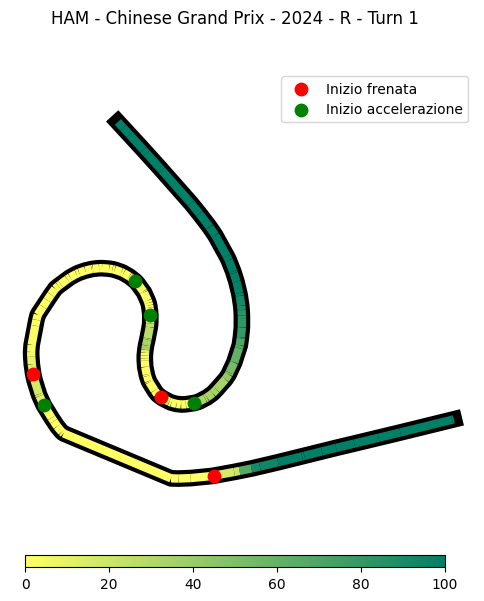

In [120]:
x = turn_tel['X']
y = turn_tel['Y']
color = turn_tel['Throttle']

points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Extract the brake and acceleration points
brk = turn_tel['Brake'].astype(int)
# Identifies the start of braking as the point where the brake value changes from 0 to 1
mask_brake_start = brk.diff() == 1
# Get the coordinates of the braking points using a boolean mask
brake_pts = turn_tel.loc[mask_brake_start, ['X','Y']]

# Throttle ≤5%→>5%
thr = turn_tel['Throttle']
# Identifies the start of acceleration as the point where the throttle value changes from ≤5% to >5% (arbitrary threshold)
mask_accel_start = (thr > 5) & (thr.shift(1) <= 5)
# Get the coordinates of the acceleration points using a boolean mask
accel_pts = turn_tel.loc[mask_accel_start, ['X','Y']]


fig, ax = plt.subplots(figsize=(6,6))
fig.suptitle(f"{driver} - {weekend.EventName} - {session.event.year} - {ses} - Turn {turn.loc[0,'Number']}")

# (A) tracciato di base con il giro più veloce
ax.plot(x, y, color='black', linewidth=12, zorder=0)

norm = mpl.colors.Normalize(color.min(), color.max())
lc = LineCollection(segments, cmap=colormap, norm=norm,
                  linestyle = '-', linewidth=6)
lc.set_array(color)
line = ax.add_collection(lc)

cbaxes = fig.add_axes([0.15, 0.05, 0.7, 0.02])
normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
legend = mpl.colorbar.ColorbarBase(cbaxes, cmap=colormap,
                                  norm=normlegend, orientation='horizontal')


# (B) scatter dei punti per la curva selezionata
ax.scatter(brake_pts['X'],  brake_pts['Y'],
           c='red',   s=80, label='Inizio frenata',    zorder=2)
ax.scatter(accel_pts['X'], accel_pts['Y'],
           c='green', s=80, label='Inizio accelerazione', zorder=2)

ax.axis('equal')
ax.axis('off')
ax.legend(loc='upper right', frameon=True)

plt.show()

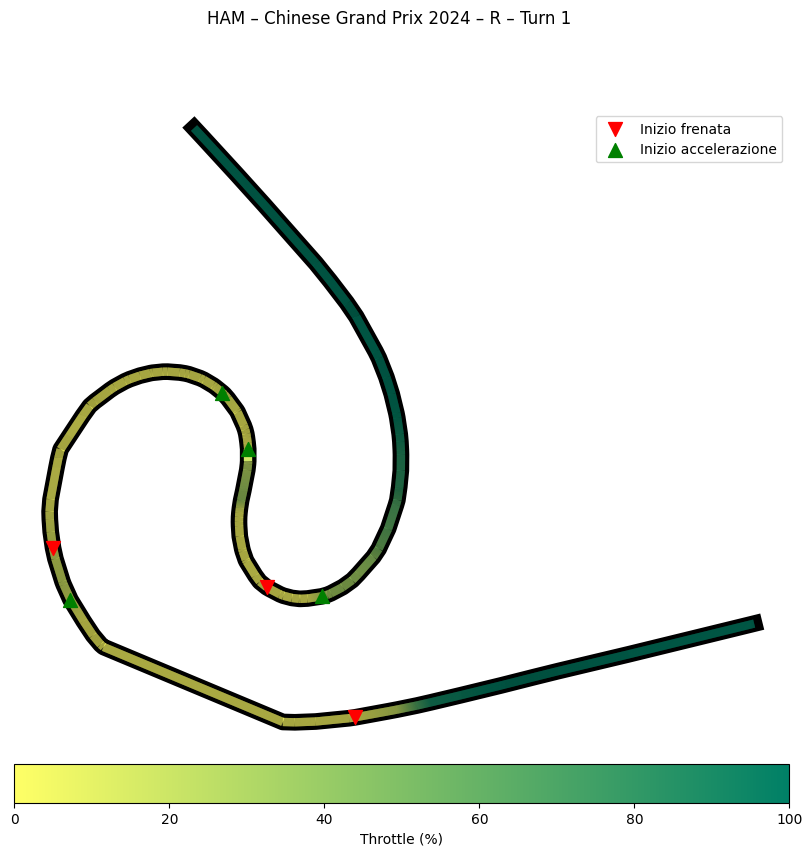

In [122]:
# --- Parametri di up-sampling ---
n_sub = 100  # numero di sotto-segmenti per ogni tratto originale

# --- Estrazione dai dati originali ---
dist   = turn_tel['Distance'].values    # distanza cumulata [m]
x      = turn_tel['X'].values           # coordinate originali X
y      = turn_tel['Y'].values           # coordinate originali Y
th     = turn_tel['Throttle'].values    # apertura gas [0–100]

# --- Griglia fine su Distance ---
dist_fine = np.linspace(dist.min(), dist.max(),
                        (len(dist) - 1) * n_sub + 1)

# --- Interpolazione lineare in funzione di Distance ---
x_fine     = np.interp(dist_fine, dist, x)
y_fine     = np.interp(dist_fine, dist, y)
th_fine    = np.interp(dist_fine, dist, th)

# --- Generazione dei segments per LineCollection ---
points   = np.vstack([x_fine, y_fine]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# --- Ricalcolo dei punti di frenata/accelerazione ---
# (rimangono basati sulla telemetria originale)
brk = turn_tel['Brake'].astype(int)
mask_brake_start = brk.diff() == 1
brake_pts = turn_tel.loc[mask_brake_start, ['X','Y']]

thr = turn_tel['Throttle']
mask_accel_start = (thr > 5) & (thr.shift(1) <= 5)
accel_pts = turn_tel.loc[mask_accel_start, ['X','Y']]

# --- Plotting ---
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle(f"{driver} – {weekend.EventName} {session.event.year} – {ses} – Turn {turn.loc[0,'Number']}")

# (1) tracciato di sfondo
ax.plot(x, y, color='black', linewidth=12, zorder=0)

# (2) linea colorata con throttle interpolato
norm = mpl.colors.Normalize(vmin=th.min(), vmax=th.max())
lc = LineCollection(segments, cmap=colormap, norm=norm, linewidth=6, antialiaseds=True)
lc.set_array(th_fine)
ax.add_collection(lc)

# colorbar orizzontale
cbar = fig.colorbar(lc, ax=ax, orientation='horizontal', pad=0.03)
cbar.set_label('Throttle (%)')

# (3) marker di inizio frenata e accelerazione
ax.scatter(brake_pts['X'],  brake_pts['Y'],
           c='red',   s=100, marker='v', label='Inizio frenata',    zorder=2)
ax.scatter(accel_pts['X'], accel_pts['Y'],
           c='green', s=100, marker='^', label='Inizio accelerazione', zorder=2)

# stile finale
ax.axis('equal')
ax.axis('off')
ax.legend(loc='upper right', frameon=True)

plt.show()

Plotting the Brake Points and the Acceleration Points for the Fastest Lap of the Circuit

In [ ]:
# # Extract the brake and acceleration points
# brk = turn_tel['Brake'].astype(int)
# # Identifies the start of braking as the point where the brake value changes from 0 to 1
# mask_brake_start = brk.diff() == 1
# # Get the coordinates of the braking points using a boolean mask
# brake_pts = turn_tel.loc[mask_brake_start, ['X','Y']]

# # Throttle ≤5%→>5%
# thr = turn_tel['Throttle']
# # Identifies the start of acceleration as the point where the throttle value changes from ≤5% to >5% (arbitrary threshold)
# mask_accel_start = (thr > 5) & (thr.shift(1) <= 5)
# # Get the coordinates of the acceleration points using a boolean mask
# accel_pts = turn_tel.loc[mask_accel_start, ['X','Y']]


# fig, ax = plt.subplots(figsize=(6,6))
# fig.suptitle(f"{driver} - {weekend.EventName} - {session.event.year} - {ses} - Turn {turn.loc[0,'Number']}")

# # (A) tracciato di base con il giro più veloce
# ax.plot(turn_tel['X'], turn_tel['Y'], color='black', linewidth=12, zorder=0)


# # (B) scatter dei punti per la curva selezionata
# ax.scatter(brake_pts['X'],  brake_pts['Y'],
#            c='red',   s=80, label='Inizio frenata',    zorder=1)
# ax.scatter(accel_pts['X'], accel_pts['Y'],
#            c='green', s=80, label='Inizio accelerazione', zorder=1)

# ax.axis('equal')
# ax.axis('off')
# ax.legend(loc='upper right', frameon=True)

# plt.show()